In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


In [4]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pickling.
notMNIST_large/G.pickle already present - Skipping pickling.
notMNIST_large/H.pickle already present - Skipping pickling.
notMNIST_large/I.pickle already present - Skipping pickling.
notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/A.pickle already present - Skipping pickling.
notMNIST_small/B.pickle already present - Skipping pickling.
notMNIST_small/C.pickle already present - Skipping pickling.
notMNIST_small/D.pickle already present - Skipping pickling.
notMNIST_small/E.pickle already present - Skipping pickling.
notMNIST_small/F.pickle already present - Skipping pickling.
notMNIST_small/G.pickle 

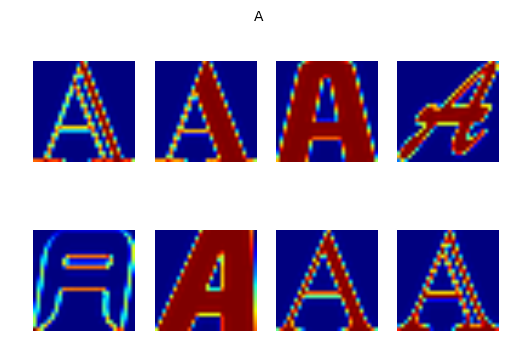

In [7]:
def disp_8_img(imgs, titles):
  """Display subplot with 8 images or less"""
  for i, img in enumerate(imgs):
    plt.subplot(2, 4, i+1)
    plt.title(titles[i])
    plt.axis('off')
    plt.imshow(img)

def disp_sample_pickles(data_folders):
  folder = random.sample(data_folders, 1)
  pickle_filename = ''.join(folder) + '.pickle'
  try:
    with open(pickle_filename, 'rb') as f:
      dataset = pickle.load(f)
  except Exception as e:
    print('Unable to read data from', pickle_filename, ':', e)
    return
  # display
  plt.suptitle(''.join(folder)[-1])
  for i, img in enumerate(random.sample(list(dataset), 8)):
    #print ("inside ")
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    plt.imshow(img)
import random 

disp_sample_pickles(train_folders)
disp_sample_pickles(test_folders)

In [8]:
def disp_number_images(data_folders):
  for folder in data_folders:
    pickle_filename = ''.join(folder) + '.pickle'
    try:
      with open(pickle_filename, 'rb') as f:
        dataset = pickle.load(f)
    except Exception as e:
      print('Unable to read data from', pickle_filename, ':', e)
      return
    print('Number of images in ', folder, ' : ', len(dataset))
    
disp_number_images(train_folders)
disp_number_images(test_folders) 

Number of images in  notMNIST_large/A  :  52909
Number of images in  notMNIST_large/B  :  52911
Number of images in  notMNIST_large/C  :  52912
Number of images in  notMNIST_large/D  :  52911
Number of images in  notMNIST_large/E  :  52912
Number of images in  notMNIST_large/F  :  52912
Number of images in  notMNIST_large/G  :  52912
Number of images in  notMNIST_large/H  :  52912
Number of images in  notMNIST_large/I  :  52912
Number of images in  notMNIST_large/J  :  52911
Number of images in  notMNIST_small/A  :  1872
Number of images in  notMNIST_small/B  :  1873
Number of images in  notMNIST_small/C  :  1873
Number of images in  notMNIST_small/D  :  1873
Number of images in  notMNIST_small/E  :  1873
Number of images in  notMNIST_small/F  :  1872
Number of images in  notMNIST_small/G  :  1872
Number of images in  notMNIST_small/H  :  1872
Number of images in  notMNIST_small/I  :  1872
Number of images in  notMNIST_small/J  :  1872


In [10]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [11]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [59]:

pretty_labels = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J'}

def display_sample_dataset(dataset, labels):
  items = random.sample(range(len(labels)), 8)
  for i, item in enumerate(items):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    plt.title(pretty_labels[labels[item]])
    plt.imshow(dataset[item])




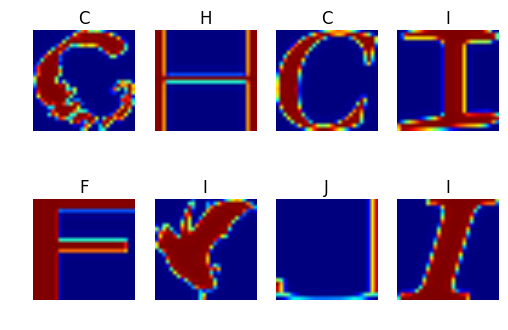

In [60]:
display_sample_dataset(train_dataset, train_labels)

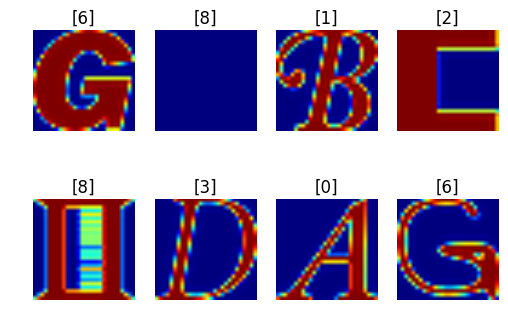

In [18]:
display_sample_dataset(valid_dataset, valid_labels)

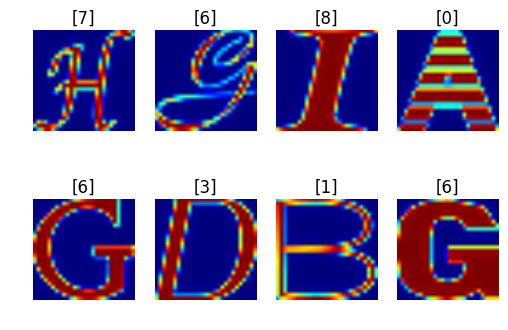

In [19]:
display_sample_dataset(test_dataset, test_labels)

In [20]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [21]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800512


In [37]:
def display_overlap(overlap, source_dataset, target_dataset):
  item = random.choice(list(overlap.keys()))
  imgs = np.concatenate(([source_dataset[item]], target_dataset[overlap[item][0:7]]))
  plt.suptitle(item)
  for i, img in enumerate(imgs):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    plt.imshow(img)

In [23]:
def extract_overlap(dataset_1, dataset_2):
  overlap = {}
  for i, img_1 in enumerate(dataset_1):
    for j, img_2 in enumerate(dataset_2):     
      if np.array_equal(img_1, img_2):
        if not i in overlap.keys():
          overlap[i] = []
        overlap[i].append(j)
  return overlap

In [24]:
%time overlap_test_train = extract_overlap(test_dataset[:200], train_dataset)

CPU times: user 3min 35s, sys: 1.36 s, total: 3min 36s
Wall time: 3min 36s


Number of overlaps: 56


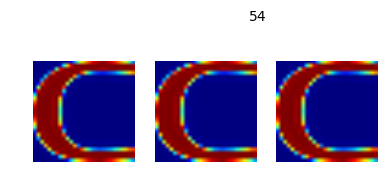

In [38]:
print('Number of overlaps:', len(overlap_test_train.keys()))
display_overlap(overlap_test_train, test_dataset[:200], train_dataset)

In [30]:


MAX_MANHATTAN_NORM = 10

def extract_overlap_near(dataset_1, dataset_2):
  overlap = {}
  for i, img_1 in enumerate(dataset_1):
    for j, img_2 in enumerate(dataset_2):
      diff = img_1 - img_2
      m_norm = np.sum(np.abs(diff))
      if m_norm < MAX_MANHATTAN_NORM:
        if not i in overlap.keys():
          overlap[i] = []
        overlap[i].append(j)
  return overlap



In [ ]:
%time overlap_test_train_near = extract_overlap_near(test_dataset[:200], train_dataset)

In [39]:
print('Number of near overlaps:', len(overlap_test_train_near.keys()))
display_overlap(overlap_test_train_near, test_dataset[:200], train_dataset)

NameError: name 'overlap_test_train_near' is not defined

In [33]:
def extract_overlap_stop(dataset_1, dataset_2):
  overlap = {}
  for i, img_1 in enumerate(dataset_1):
    for j, img_2 in enumerate(dataset_2):     
      if np.array_equal(img_1, img_2):
        overlap[i] = [j]
        break
  return overlap

In [ ]:
%time overlap_test_train = extract_overlap_stop(test_dataset[:200], train_dataset)

Number of overlaps: 56


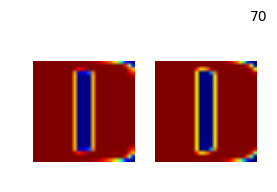

In [40]:
print('Number of overlaps:', len(overlap_test_train.keys()))
display_overlap(overlap_test_train, test_dataset[:200], train_dataset)

In [34]:
MAX_MANHATTAN_NORM = 10

def extract_overlap_where(dataset_1, dataset_2):
  overlap = {}
  for i, img_1 in enumerate(dataset_1):
    diff = dataset_2 - img_1
    norm = np.sum(np.abs(diff), axis=1)
    duplicates = np.where(norm < MAX_MANHATTAN_NORM)
    if len(duplicates[0]):
      overlap[i] = duplicates[0]
  return overlap

In [35]:
test_flat = test_dataset.reshape(test_dataset.shape[0], 28 * 28)
train_flat = train_dataset.reshape(train_dataset.shape[0], 28 * 28)
%time overlap_test_train = extract_overlap_where(test_flat[:200], train_flat)

CPU times: user 1min 29s, sys: 1min 32s, total: 3min 1s
Wall time: 3min 2s


Number of overlaps: 56


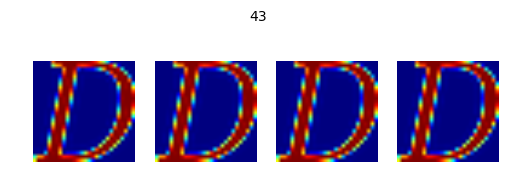

In [41]:
print('Number of overlaps:', len(overlap_test_train.keys()))
display_overlap(overlap_test_train, test_dataset[:200], train_dataset)

In [44]:
import hashlib 
def extract_overlap_hash(dataset_1, dataset_2):
  dataset_hash_1 = [hashlib.sha256(img).hexdigest() for img in dataset_1]
  dataset_hash_2 = [hashlib.sha256(img).hexdigest() for img in dataset_2]
  overlap = {}
  for i, hash1 in enumerate(dataset_hash_1):
    for j, hash2 in enumerate(dataset_hash_2):
      if hash1 == hash2:
        if not i in overlap.keys():
          overlap[i] = []
        overlap[i].append(j) ## use np.where
  return overlap

In [45]:
%time overlap_test_train = extract_overlap_hash(test_dataset[:200], train_dataset)

CPU times: user 5.06 s, sys: 35.6 ms, total: 5.1 s
Wall time: 5.1 s


Number of overlaps: 24


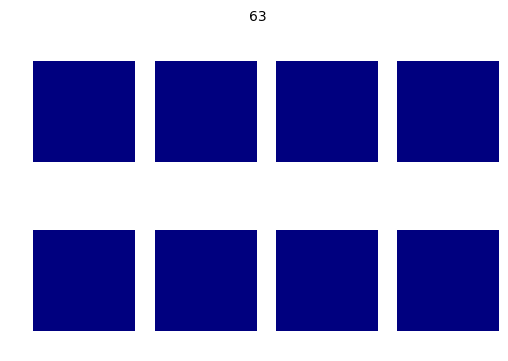

In [46]:
print('Number of overlaps:', len(overlap_test_train.keys()))
display_overlap(overlap_test_train, test_dataset[:200], train_dataset)

In [47]:
def extract_overlap_hash_where(dataset_1, dataset_2):
  dataset_hash_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_1])
  dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_2])
  overlap = {}
  for i, hash1 in enumerate(dataset_hash_1):
    duplicates = np.where(dataset_hash_2 == hash1)
    if len(duplicates[0]):
      overlap[i] = duplicates[0]
  return overlap

In [48]:
%time overlap_test_train = extract_overlap_hash_where(test_dataset[:200], train_dataset)

CPU times: user 3.09 s, sys: 80.1 ms, total: 3.17 s
Wall time: 3.18 s


Number of overlaps: 24


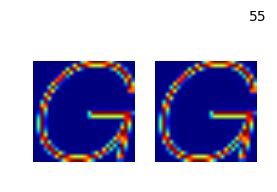

In [49]:
print('Number of overlaps:', len(overlap_test_train.keys()))
display_overlap(overlap_test_train, test_dataset[:200], train_dataset)

In [50]:


def sanetize(dataset_1, dataset_2, labels_1):
  dataset_hash_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_1])
  dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_2])
  overlap = [] # list of indexes
  for i, hash1 in enumerate(dataset_hash_1):
    duplicates = np.where(dataset_hash_2 == hash1)
    if len(duplicates[0]):
      overlap.append(i) 
  return np.delete(dataset_1, overlap, 0), np.delete(labels_1, overlap, None)



In [51]:
%time test_dataset_sanit, test_labels_sanit = sanetize(test_dataset[:200], train_dataset, test_labels[:200])
print('Overlapping images removed: ', len(test_dataset[:200]) - len(test_dataset_sanit))

CPU times: user 3 s, sys: 74.3 ms, total: 3.08 s
Wall time: 3.08 s
Overlapping images removed:  24


In [52]:
%time test_dataset_sanit, test_labels_sanit = sanetize(test_dataset, train_dataset, test_labels)
print('Overlapping images removed: ', len(test_dataset) - len(test_dataset_sanit))

CPU times: user 47.4 s, sys: 259 ms, total: 47.7 s
Wall time: 47.8 s
Overlapping images removed:  1301


In [53]:
%time valid_dataset_sanit, valid_labels_sanit = sanetize(valid_dataset, train_dataset, valid_labels)
print('Overlapping images removed: ', len(valid_dataset) - len(valid_dataset_sanit))

CPU times: user 48 s, sys: 226 ms, total: 48.2 s
Wall time: 48.3 s
Overlapping images removed:  1097


In [54]:
pickle_file_sanit = 'notMNIST_sanit.pickle'

try:
  f = open(pickle_file_sanit, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset_sanit,
    'valid_labels': valid_labels_sanit,
    'test_dataset': test_dataset_sanit,
    'test_labels': test_labels_sanit,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [55]:
statinfo = os.stat(pickle_file_sanit)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 683270792


In [56]:
regr = LogisticRegression()
X_test = test_dataset.reshape(test_dataset.shape[0], 28 * 28)
y_test = test_labels

In [57]:
sample_size = 50
X_train = train_dataset[:sample_size].reshape(sample_size, 784)
y_train = train_labels[:sample_size]
%time regr.fit(X_train, y_train)
regr.score(X_test, y_test)

CPU times: user 58.1 ms, sys: 2.96 ms, total: 61 ms
Wall time: 66.1 ms


0.60819999999999996

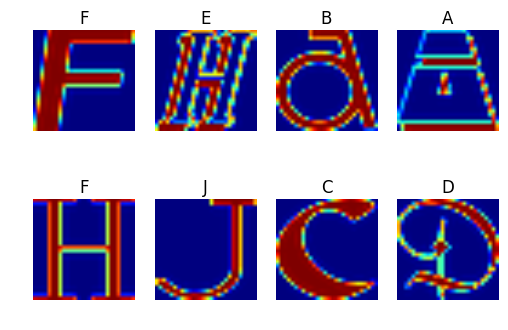

In [62]:
pred_labels = regr.predict(X_test)
display_sample_dataset(test_dataset, pred_labels)

In [63]:
sample_size = 100
X_train = train_dataset[:sample_size].reshape(sample_size, 784)
y_train = train_labels[:sample_size]
%time regr.fit(X_train, y_train)
regr.score(X_test, y_test)

CPU times: user 117 ms, sys: 1.47 ms, total: 118 ms
Wall time: 117 ms


0.70820000000000005

In [64]:
sample_size = 1000
X_train = train_dataset[:sample_size].reshape(sample_size, 784)
y_train = train_labels[:sample_size]
%time regr.fit(X_train, y_train)
regr.score(X_test, y_test)

CPU times: user 2.37 s, sys: 13.8 ms, total: 2.38 s
Wall time: 2.39 s


0.82920000000000005

In [65]:
X_valid = valid_dataset[:sample_size].reshape(sample_size, 784)
y_valid = valid_labels[:sample_size]
regr.score(X_valid, y_valid)

0.77500000000000002

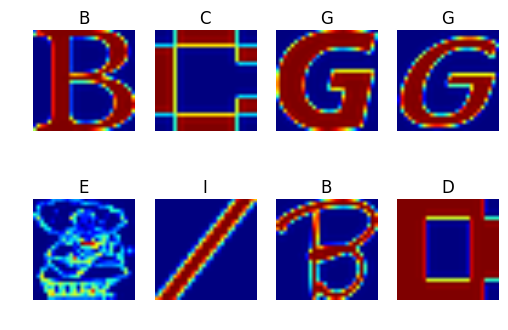

In [67]:
pred_labels = regr.predict(X_valid)
display_sample_dataset(valid_dataset, pred_labels)

In [68]:
sample_size = 5000
X_train = train_dataset[:sample_size].reshape(sample_size, 784)
y_train = train_labels[:sample_size]
%time regr.fit(X_train, y_train)
regr.score(X_test, y_test)

CPU times: user 21.2 s, sys: 91.8 ms, total: 21.3 s
Wall time: 21.4 s


0.84619999999999995

In [69]:
regr2 = LogisticRegression(solver='sag')
sample_size = len(train_dataset)
X_train = train_dataset[:sample_size].reshape(sample_size, 784)
y_train = train_labels[:sample_size]
%time regr2.fit(X_train, y_train)
regr2.score(X_test, y_test)

CPU times: user 9min 11s, sys: 2.45 s, total: 9min 13s
Wall time: 9min 15s


0.8901

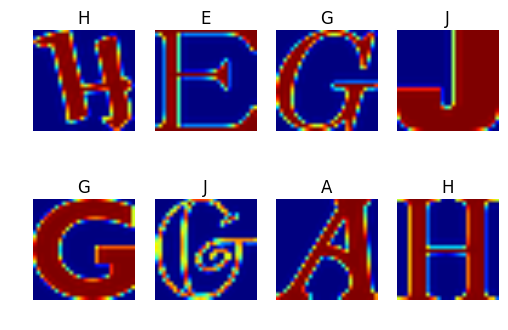

In [71]:
pred_labels = regr.predict(X_test)
display_sample_dataset(test_dataset, pred_labels)